In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import atan, sin, cos
import numpy as np

In [2]:
def show_3d(vertices, edges):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    plt.show()

def show_2d(vertices, edges, size):
    fig = plt.figure()
    ax = fig.gca()
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plt([p1[0], p2[0]],
                [p1[1], p2[1]])
    ax.set_ylim(0, size[0])
    ax.set_xlim(0, size[1])
    plt.show()

In [3]:
def to_homogeneous(coords):
    h_coord = []
    
    for c in coords:
        c = np.append(c,np.array([1]))
        h_coord.append(c)

    return np.array(h_coord)

def from_homogeneous(coords):
    w_coord = []
    for c in coords:
        if c.shape[0] == 4:
            c = c/c[3]
            c = c[:3]

            w_coord.append(c)

        else:
            c = c/c[2]
            c = c[:2]

            w_coord.append(c)

    return np.array(w_coord)

In [4]:
def create_rotation(u, theta):
    rotation_matrix = np.eye(4)

    rotation_matrix[0][0] = cos(theta) + u[0]**2*(1-cos(theta))
    rotation_matrix[0][1] = u[0]*u[1]*(1-cos(theta)) - u[2]*sin(theta)
    rotation_matrix[0][2] = u[0]*u[2]*(1-cos(theta)) + u[1]*sin(theta)
    rotation_matrix[1][0] = u[1]*u[0]*(1-cos(theta)) + u[2]*sin(theta)
    rotation_matrix[1][1] = cos(theta) + u[1]**2*(1-cos(theta))
    rotation_matrix[1][2] = u[1]*u[2]*(1-cos(theta)) - u[0]*sin(theta)
    rotation_matrix[2][0] = u[2]*u[0]*(1-cos(theta)) - u[1]*sin(theta)
    rotation_matrix[2][1] = u[2]*u[1]*(1-cos(theta)) + u[0]*sin(theta)
    rotation_matrix[2][2] = cos(theta) + u[2]**2*(1-cos(theta))

    return rotation_matrix

In [5]:
def create_translation(translate):
    translation_matrix = np.eye(4)
    translation_matrix[0][3] = translate[0]
    translation_matrix[1][3] = translate[1]
    translation_matrix[2][3] = translate[2]

    return translation_matrix

In [6]:
def get_extrinsic_matrix(position, orientation):    
    angle_x = orientation[0]
    angle_y = orientation[1]
    angle_z = orientation[2]
    R_x = create_rotation([1,0,0], angle_x)
    R_y = create_rotation([0,1,0], angle_y)
    R_z = create_rotation([0,0,1], angle_z)

    trainslation_matrix = create_translation(-position)


    rotation_matrix = R_x @ R_y @ R_z

    extrinsic_matrix = rotation_matrix @ trainslation_matrix

    return extrinsic_matrix

In [7]:
corners = np.array([[-1, -1, -1],
                    [1, -1, -1 ],
                    [1, 1, -1],
                    [-1, 1, -1],
                    [-1, -1, 1],
                    [1, -1, 1 ],
                    [1, 1, 1],
                    [-1, 1, 1]])

edges = np.array([(0,1), (0,3), (1,2), (2,3), (4,5), (4,7), (5,6), (6,7), (1,5), (2,6), (3,7), (0,4)])
camera_position = np.array([0, 0, -2.5])
camera_orientation = np.array([0, 0.1, 0])

/tmp/ipykernel_2460/3025078508.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


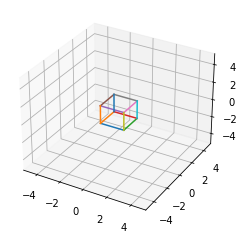

In [8]:
show_3d(corners, edges)

In [9]:
homogeneous_coord = to_homogeneous(corners)
extrinsic_matrix = get_extrinsic_matrix(camera_position, camera_orientation)

In [10]:
homogeneous_corners = []

for h in homogeneous_coord:
    temp = extrinsic_matrix @ h
    homogeneous_corners.append(temp)

homogeneous_corners = np.array(homogeneous_corners)
c_coords = from_homogeneous(homogeneous_corners)

/tmp/ipykernel_2460/3025078508.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


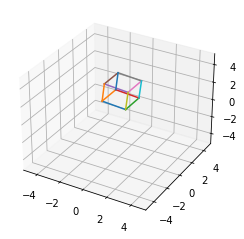

In [11]:
show_3d(c_coords, edges)